# NFL Win Prediction
Notebook uses an xgboost classifier model to predict whether the home team wins in an NFL game. Scores and stats come from pro-football-reference.com. The model is fit on a random 80% sample of NFL games from 2017-2020 and a 20% holdout is used for testing and validation. 

## Data Prep

In [101]:
import pandas as pd
import numpy as np

from sklearn import metrics
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import shap

from xgboost import plot_importance


In [102]:
def rename_cols(df, suff):
    for column in df.columns[2:]:
        df = df.rename(columns={column : column+suff})
    df['Tm'] = df['Tm'].str.split().str[-1]
    df['Tm'] = df['Tm'].str.replace('Team', 'WFT').replace('Redskins', 'WFT')
    return df

In [103]:
def find_streaks(df):
    df_list =[]
    for year in df['Year'].unique():
        for team in df['Home'].unique():
            streak = 0
            temp = df[df['Year']==year][['Year','Week','Home', 'Away', 'Win']].copy()
            temp['Team'] = team
            temp = temp[(temp['Home'] == team) | (temp['Away']== team)]
            temp = temp.sort_values(by='Week', ascending=True).reset_index(drop=True)
            for index, row in temp.iterrows():
                win = False
                if (((row['Win']==True) == (row['Home']==team)) | ((row['Win']==False) == (row['Away']==team))):
                    win = True
                if win:
                    if streak < 0:
                        streak = 0
                    else:
                        streak += 1
                else:
                    if streak < 0:
                        streak -= 1
                    else:
                        streak = 0
                temp.loc[index+1,'Streak'] = streak
            temp = temp[['Year','Week','Team', 'Streak']].copy()
            df_list.append(temp.copy())

    return pd.concat(df_list).fillna(0)

In [104]:
scores = pd.read_csv('data/nfl_scores_17_20.csv')
scores = scores.drop(columns=scores.columns[0])
scores['Win'] = scores['Score_Home']>scores['Score_Away']

pass_o = pd.read_csv('data/passing_17_20.csv')
rushing_o = pd.read_csv('data/rushing_17_20.csv')

pass_d = pd.read_csv('data/passing_d_17_20.csv')
rushing_d = pd.read_csv('data/rushing_d_17_20.csv')

pass_o = rename_cols(pass_o, '_pass_o')
rushing_o = rename_cols(rushing_o, '_rush_o')
offense = pass_o.merge(rushing_o, on=['Year', 'Tm'])

pass_d = rename_cols(pass_d, '_pass_d')
rushing_d = rename_cols(rushing_d, '_rush_d')
defense = pass_d.merge(rushing_d, on=['Year', 'Tm'])

In [105]:
defense.head()

,Year,Tm,G_pass_d,Cmp_pass_d,Att_pass_d,Cmp%_pass_d,Yds_pass_d,TD_pass_d,TD%_pass_d,Int_pass_d,...,ANY/A_pass_d,Sk%_pass_d,EXP_pass_d,G_rush_d,Att_rush_d,Yds_rush_d,TD_rush_d,Y/A_rush_d,Y/G_rush_d,EXP_rush_d
0,2017,Jaguars,16,289,509,56.8,2718,17,3.3,21,...,3.7,9.8,124.41,16,429,1860,9,4.3,116.3,130.30
1,2017,Vikings,16,324,555,58.4,3078,13,2.3,14,...,4.6,6.3,71.51,16,364,1337,10,3.7,83.6,73.80
2,2017,Chargers,16,329,524,62.8,3156,17,3.2,18,...,4.7,7.6,84.23,16,430,2098,11,4.9,131.1,32.37
3,2017,Broncos,16,294,491,59.9,3210,29,5.9,10,...,6.4,6.3,-23.04,16,428,1430,9,3.3,89.4,145.96
4,2017,Steelers,16,297,499,59.5,3217,20,4.0,16,...,5.2,10.1,15.99,16,385,1693,14,4.4,105.8,8.03


In [106]:
offense.head()

,Year,Tm,G_pass_o,Cmp_pass_o,Att_pass_o,Cmp%_pass_o,Yds_pass_o,TD_pass_o,TD%_pass_o,Int_pass_o,...,EXP_pass_o,G_rush_o,Att_rush_o,Yds_rush_o,TD_rush_o,Lng_rush_o,Y/A_rush_o,Y/G_rush_o,Fmb_rush_o,EXP_rush_o
0,2017,Chargers,16,366,583,62.8,4431,28,4.8,11,...,85.54,16,419,1595,10,87,3.8,99.7,17,-93.07
1,2017,Patriots,16,389,587,66.3,4418,32,5.5,8,...,197.94,16,448,1889,16,44,4.2,118.1,13,-87.22
2,2017,Steelers,16,384,590,65.1,4380,29,4.9,15,...,84.45,16,437,1667,12,29,3.8,104.2,15,-116.88
3,2017,Buccaneers,16,378,605,62.5,4366,26,4.3,14,...,41.13,16,390,1448,8,36,3.7,90.5,27,-82.91
4,2017,Saints,16,386,536,72.0,4189,23,4.3,8,...,78.77,16,444,2070,23,74,4.7,129.4,19,-71.76


In [107]:
print(len(scores))

1024


In [108]:
scores = scores.merge(offense, left_on=['Year', 'Home'], right_on=['Year', 'Tm'])
scores = scores.drop(columns='Tm')
scores = scores.merge(defense, left_on=['Year', 'Home'], right_on=['Year', 'Tm'])
scores = scores.drop(columns='Tm')

scores = scores.merge(offense, left_on=['Year', 'Away'], right_on=['Year', 'Tm'], suffixes=('', '_Away'))
scores = scores.drop(columns='Tm')
scores = scores.merge(defense, left_on=['Year', 'Away'], right_on=['Year', 'Tm'], suffixes=('', '_Away'))
scores = scores.drop(columns='Tm')

print(len(scores))

scores

1024


,Year,Week,Home,Away,Score_Home,Score_Away,Win,G_pass_o,Cmp_pass_o,Att_pass_o,...,ANY/A_pass_d_Away,Sk%_pass_d_Away,EXP_pass_d_Away,G_rush_d_Away,Att_rush_d_Away,Yds_rush_d_Away,TD_rush_d_Away,Y/A_rush_d_Away,Y/G_rush_d_Away,EXP_rush_d_Away
0,2017,1,Patriots,Chiefs,27,42,False,16,389,587,...,6.1,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69
1,2017,5,Texans,Chiefs,34,42,False,16,299,525,...,6.1,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69
2,2017,9,Cowboys,Chiefs,28,17,True,16,309,493,...,6.1,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69
3,2017,17,Broncos,Chiefs,24,27,False,16,332,566,...,6.1,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69
4,2017,3,Chargers,Chiefs,10,24,False,16,366,583,...,6.1,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,2020,10,Bears,Vikings,13,19,False,16,402,614,...,7.2,4.1,-149.87,16,472,2151,19,4.6,134.4,-41.77
1020,2020,14,Buccaneers,Vikings,26,14,True,16,410,626,...,7.2,4.1,-149.87,16,472,2151,19,4.6,134.4,-41.77
1021,2020,8,Packers,Vikings,22,28,False,16,372,526,...,7.2,4.1,-149.87,16,472,2151,19,4.6,134.4,-41.77
1022,2020,4,Texans,Vikings,23,31,False,16,383,546,...,7.2,4.1,-149.87,16,472,2151,19,4.6,134.4,-41.77


In [109]:
scores['Win'] = scores['Win'].astype('bool')
streaks = find_streaks(scores)
scores = scores.merge(streaks, left_on=['Year', 'Week', 'Home'], right_on=['Year', 'Week', 'Team'])
scores = scores.drop(columns=['Team'])
scores = scores.rename(columns={'Streak':'Streak_Home'})
scores = scores.merge(streaks, left_on=['Year', 'Week', 'Away'], right_on=['Year', 'Week', 'Team'])
scores = scores.drop(columns=['Team'])
scores = scores.rename(columns={'Streak':'Streak_Away'})

year_weights_dict = {
    0:{'Year':2017, 'Weight':.1},
    1:{'Year':2018,'Weight':.2},
    2:{'Year':2019,'Weight':.3},
    3:{'Year':2020,'Weight':.4}
    }

scores = scores.merge(pd.DataFrame.from_dict(year_weights_dict).T, on='Year', how='left')

scores

,Year,Week,Home,Away,Score_Home,Score_Away,Win,G_pass_o,Cmp_pass_o,Att_pass_o,...,G_rush_d_Away,Att_rush_d_Away,Yds_rush_d_Away,TD_rush_d_Away,Y/A_rush_d_Away,Y/G_rush_d_Away,EXP_rush_d_Away,Streak_Home,Streak_Away,Weight
0,2017,1,Patriots,Chiefs,27,42,False,16,389,587,...,16,443,1890,15,4.3,118.1,56.69,0.0,0.0,0.1
1,2017,5,Texans,Chiefs,34,42,False,16,299,525,...,16,443,1890,15,4.3,118.1,56.69,1.0,4.0,0.1
2,2017,9,Cowboys,Chiefs,28,17,True,16,309,493,...,16,443,1890,15,4.3,118.1,56.69,2.0,1.0,0.1
3,2017,17,Broncos,Chiefs,24,27,False,16,332,566,...,16,443,1890,15,4.3,118.1,56.69,0.0,3.0,0.1
4,2017,3,Chargers,Chiefs,10,24,False,16,366,583,...,16,443,1890,15,4.3,118.1,56.69,0.0,2.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,2020,10,Bears,Vikings,13,19,False,16,402,614,...,16,472,2151,19,4.6,134.4,-41.77,0.0,2.0,0.4
1020,2020,14,Buccaneers,Vikings,26,14,True,16,410,626,...,16,472,2151,19,4.6,134.4,-41.77,0.0,2.0,0.4
1021,2020,8,Packers,Vikings,22,28,False,16,372,526,...,16,472,2151,19,4.6,134.4,-41.77,1.0,0.0,0.4
1022,2020,4,Texans,Vikings,23,31,False,16,383,546,...,16,472,2151,19,4.6,134.4,-41.77,0.0,0.0,0.4


In [110]:
pd.DataFrame.from_dict(year_weights_dict).T

,Year,Weight
0,2017.0,0.1
1,2018.0,0.2
2,2019.0,0.3
3,2020.0,0.4


In [111]:
for index, x in scores.corrwith(scores['Win']).sort_values().items():
    print(f'{index}: {x}')

Score_Away: -0.5578110427553424
ANY/A_pass_o_Away: -0.2956812870721108
EXP_pass_o_Away: -0.2894799330182331
Rate_pass_o_Away: -0.2881630459328107
AY/A_pass_o_Away: -0.2710428731860085
TD%_pass_o_Away: -0.263544708551115
NY/A_pass_o_Away: -0.2591214183612272
Att_rush_d: -0.2511594927237381
TD_pass_o_Away: -0.2459870273713483
TD_rush_o_Away: -0.237895060533158
Rate_pass_d: -0.2309610611535205
ANY/A_pass_d: -0.2253324740062734
Cmp%_pass_o_Away: -0.22016753111409126
AY/A_pass_d: -0.21955368904344913
Y/A_pass_o_Away: -0.21005521895732238
Yds.1_pass_d_Away: -0.20995691568498612
Yds.1_pass_o: -0.20717789828876199
Sk_pass_o: -0.20423543000095631
PD_pass_d_Away: -0.20375493871082095
Int_pass_o: -0.20036529402206318
NY/A_pass_d: -0.18833816523472746
Att_rush_o_Away: -0.1877155908632669
Int%_pass_o: -0.18553156413051825
Yds_rush_d: -0.18084793253701895
Y/G_rush_d: -0.18083694710328319
Sk_pass_d_Away: -0.17777645605196257
TD_rush_d: -0.1771945496823799
TD%_pass_d: -0.17494408155404778
Cmp%_pass_d:

## Modeling

### Split Data and Train a Bunch of Different Classifier Algorithms

In [112]:
np.random.seed(69)

full = scores.copy()

full['Rand_Int'] = np.random.randint(10,size=len(full))
full = full.fillna(0)

features = list(full.columns)
features.remove('Away')
features.remove('Weight')
features.remove('Home')
features.remove('Score_Home')
features.remove('Score_Away')
features.remove('Win')
features.remove('Rand_Int')

full_test = full[full['Rand_Int']>=8].reset_index(drop=True)
full_train = full[full['Rand_Int']<8].reset_index(drop=True)

ytrain = full_train['Win']
xtrain = full_train.drop(columns=['Win'])

ytest = full_test['Win']
xtest = full_test.drop(columns=['Win'])


RF = RandomForestClassifier(random_state = 0, max_depth=4, n_jobs=4, n_estimators=10)
SVM = SVC(random_state=0, max_iter=20, probability=True)
DT = DecisionTreeClassifier(random_state=0, max_depth=6)
XGB = XGBClassifier(random_state = 0, max_depth=4, n_jobs=4, n_estimators=10)
LG = LogisticRegression(random_state=0, n_jobs=4, max_iter=10, solver='lbfgs')

models = [RF, SVM, DT, XGB, LG]

for x in models:
    print(x)
    x.fit(xtrain[features], ytrain, sample_weight=xtrain['Weight'])

RandomForestClassifier(max_depth=4, n_estimators=10, n_jobs=4, random_state=0)
SVC(max_iter=20, probability=True, random_state=0)
DecisionTreeClassifier(max_depth=6, random_state=0)
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=4,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=4, num_parallel_tree=None, predictor=None,
              random_state=0, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
[17:33:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default e

Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


### Plot ROC Curves for Each Model
I tested a simple ensembling method that averages the probabilities from the RF and XGB algorithms. This has worked well in some other classification problems I've worked on but XGB on its own appears far and away the best.

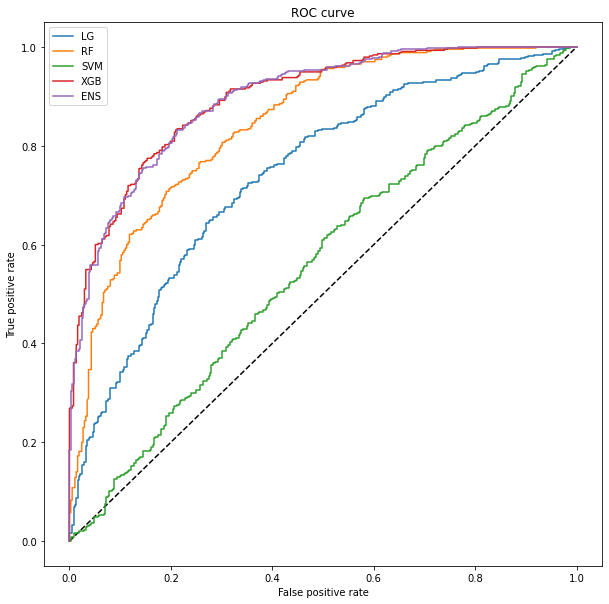

In [113]:


fpr_log, tpr_log, thresholds_log = metrics.roc_curve(ytrain, LG.predict_proba(xtrain[features])[:,1], drop_intermediate=True)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(ytrain, RF.predict_proba(xtrain[features])[:,1], drop_intermediate=True)
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(ytrain, SVM.predict_proba(xtrain[features])[:,1], drop_intermediate=True)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(ytrain, DT.predict_proba(xtrain[features])[:,1], drop_intermediate=True)
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(ytrain, XGB.predict_proba(xtrain[features])[:,1], drop_intermediate=True)
fpr_ens, tpr_ens, thresholds_ens = metrics.roc_curve(ytrain, XGB.predict_proba(xtrain[features])[:,1]*.8+RF.predict_proba(xtrain[features])[:,1]*.2, drop_intermediate=True)

plt.figure(figsize=(10,10))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_log, tpr_log, label = 'LG')
plt.plot(fpr_rf, tpr_rf, label = 'RF')
plt.plot(fpr_svm, tpr_svm, label = 'SVM')
#plt.plot(fpr_dt, tpr_dt, label = 'DT')
plt.plot(fpr_xgb, tpr_xgb, label = 'XGB')
plt.plot(fpr_ens, tpr_ens, label = 'ENS')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve')
plt.show()

### XGBoost is our best performing model, plot some information about the model including shap values and feature importances

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


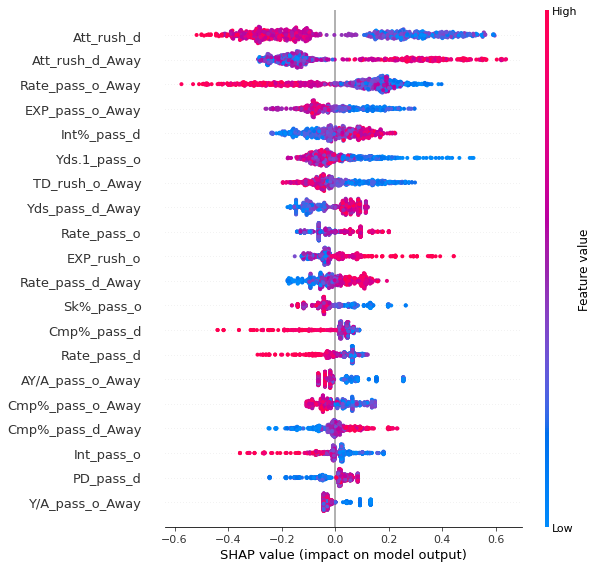

In [114]:
shapvalues = shap.TreeExplainer(XGB).shap_values(xtrain[features])


shap.summary_plot(shapvalues, xtrain[features])

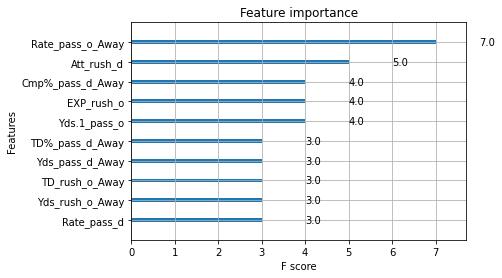

In [115]:
plot_importance(XGB, max_num_features=10)
plt.show()

In [116]:
importances_dict = {}

for i in range(0,len(features)):
    importances_dict[i] = {'feature':features[i], 'importance':(XGB.feature_importances_)[i]}

pd.DataFrame.from_dict(importances_dict).T.sort_values(by='importance', ascending=False).reset_index(drop=True).to_csv('output/football_model_importances.csv')

### Discussion

What I take away from these plots is that good teams rush the ball more. Likely this is because these teams are looking to run out the clock. A team that rushes well doesn't automatically mean that team will win, but teams that are playing ahead more often will have more rushing yards and attempts. Some passing metrics are important in determining who wins the game as well which can be expected. It's important that your offense has a high passer rating and your defense has a low passer rating against them.

### Calculate and Plot Precision at Different Thresholds

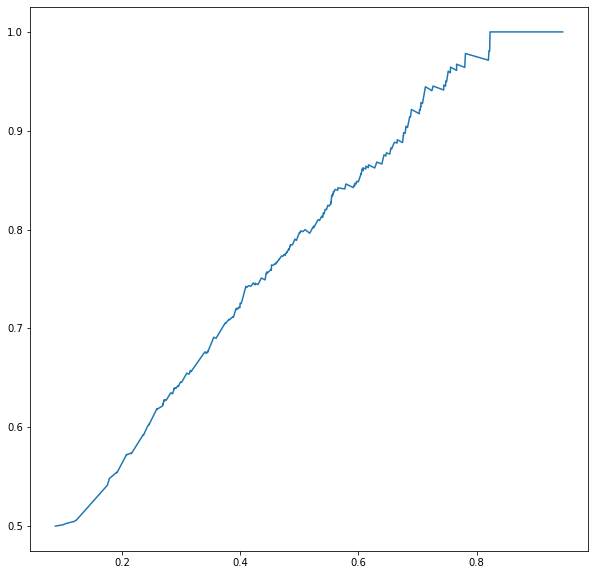

In [117]:
my_dict = {
    'fpr':fpr_xgb,
    'tpr':tpr_xgb,
    'threshold':thresholds_xgb

}

thresholds = pd.DataFrame.from_dict(my_dict)
thresholds['Precision'] = thresholds['tpr']/(thresholds['tpr']+thresholds['fpr'])

plt.figure(figsize=(10,10))
plt.plot(thresholds['threshold'], thresholds['Precision'], label = 'Precision')
plt.show()

### Choose a Threshold then Move on to Validation

In [118]:
thresh = thresholds[(thresholds['tpr']>.8)&(thresholds['fpr']<.2)].reset_index(drop=True).iloc[0,2]
thresh

0.53148174

## Run Some Validation Work on Unseen Data

In [119]:
xtest.insert(5, 'Win', ytest)
xtest.insert(5, 'proba', XGB.predict_proba(xtest[features])[:,1])
xtest.insert(5, 'pred', xtest['proba']>.578)

xtest

,Year,Week,Home,Away,Score_Home,pred,proba,Win,Score_Away,G_pass_o,...,Att_rush_d_Away,Yds_rush_d_Away,TD_rush_d_Away,Y/A_rush_d_Away,Y/G_rush_d_Away,EXP_rush_d_Away,Streak_Home,Streak_Away,Weight,Rand_Int
0,2017,5,Texans,Chiefs,34,False,0.300936,False,42,16,...,443,1890,15,4.3,118.1,56.69,1.0,4.0,0.1,9
1,2017,11,Giants,Chiefs,12,False,0.378874,True,9,16,...,443,1890,15,4.3,118.1,56.69,0.0,0.0,0.1,9
2,2017,13,Jets,Chiefs,38,False,0.289656,True,31,16,...,443,1890,15,4.3,118.1,56.69,0.0,0.0,0.1,8
3,2017,10,Rams,Texans,33,True,0.884568,True,7,16,...,440,1747,14,4.0,109.2,94.34,3.0,0.0,0.1,8
4,2017,5,Lions,Panthers,24,False,0.492095,False,27,16,...,353,1409,7,4.0,88.1,90.65,1.0,1.0,0.1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,2020,9,49ers,Packers,17,False,0.098252,False,34,16,...,397,1805,16,4.5,112.8,-36.94,0.0,0.0,0.4,8
213,2020,6,Buccaneers,Packers,38,False,0.252671,True,10,16,...,397,1805,16,4.5,112.8,-36.94,0.0,4.0,0.4,9
214,2020,10,Lions,WFT,30,False,0.254753,True,27,16,...,428,1805,14,4.2,112.8,7.17,0.0,0.0,0.4,8
215,2020,17,Lions,Vikings,35,False,0.183625,False,37,16,...,472,2151,19,4.6,134.4,-41.77,0.0,0.0,0.4,9


In [120]:
xtest['proba_bucket'] = np.floor(xtest['proba']*10)
xtest['correct'] = xtest['Win']==xtest['pred']

grp = xtest[['proba_bucket', 'correct']].groupby(['proba_bucket']).mean()
grp = grp.rename(columns={'correct':'correct_pct'})
grp = grp.join(xtest[['proba_bucket', 'correct']].groupby(['proba_bucket']).count())
grp = grp.rename(columns={'correct':'count'})

grp

,correct_pct,count
proba_bucket,,
0.0,1.000000,1
1.0,0.684211,19
2.0,0.617647,34
3.0,0.653846,26
4.0,0.500000,16
5.0,0.375000,16
6.0,0.407407,27
7.0,0.800000,40
8.0,0.885714,35


In [121]:
#Say we were using this for sports gambling purposes, if we only bet when our model estimated win probability above a certain threshold
#How many bets would we win and how many games would we bet on?
average_sum = 0
count = 0
for x in [0,6,7,8,9]:
    average_sum+=grp.iloc[x,0]*grp.iloc[x,1]
    count+=grp.iloc[x,1]

average_sum = average_sum/count
pct = count/len(xtest)

print(f'Average correct for these buckets: {average_sum}')
print(f'Number of games in these buckets: {count}')
print(f'Approx. number of games correct: {average_sum*count}')
print(f'Games in these buckets as a % of all games: {pct}')

Average correct for these buckets: 0.7358490566037735
Number of games in these buckets: 106
Approx. number of games correct: 78.0
Games in these buckets as a % of all games: 0.48847926267281105


In [122]:
grp2 = xtest[['proba_bucket', 'Win']].groupby(['proba_bucket']).sum()
grp2 = grp2.join(xtest[['proba_bucket', 'pred']].groupby(['proba_bucket']).sum())
grp2 = grp2.join(xtest[['proba_bucket', 'Week']].groupby(['proba_bucket']).count())
grp2 = grp2.rename(columns={'Week':'count'})

grp2

,Win,pred,count
proba_bucket,,,
0.0,0,0,1
1.0,6,0,19
2.0,13,0,34
3.0,9,0,26
4.0,8,0,16
5.0,9,5,16
6.0,11,27,27
7.0,32,40,40
8.0,31,35,35


In [123]:
grp2['pct'] = grp2['Win']/grp2['count']

grp2

,Win,pred,count,pct
proba_bucket,,,,
0.0,0,0,1,0.000000
1.0,6,0,19,0.315789
2.0,13,0,34,0.382353
3.0,9,0,26,0.346154
4.0,8,0,16,0.500000
5.0,9,5,16,0.562500
6.0,11,27,27,0.407407
7.0,32,40,40,0.800000
8.0,31,35,35,0.885714


In [124]:
buckets_string =[
    '0-9%',
    '10-19%',
    '20-29%',
    '30-39%',
    '40-49%',
    '50-59%',
    '60-69%',
    '70-79%',
    '80-89%',
    '90-100%'
    ]
grp2.insert(0, 'Probability Bucket', buckets_string)

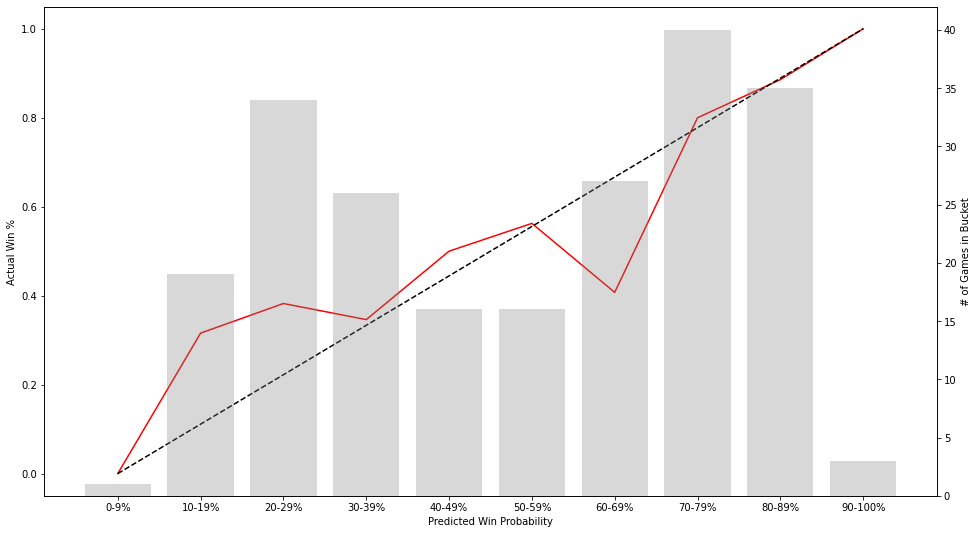

In [125]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax1.plot(grp2['Probability Bucket'], grp2['pct'], label = 'Actual Win %', color='red')
ax2 = ax1.twinx()
ax2.bar(grp2['Probability Bucket'], grp2['count'], label = '# of Games in Bucket', color='gray', alpha=.3)
ax1.plot([0,9], [0,1], 'k--')

ax1.set_xlabel('Predicted Win Probability')
ax1.set_ylabel('Actual Win %')
ax2.set_ylabel('# of Games in Bucket')
plt.show()

## Here I Fit the Model on the Full Set and Do Some Validation Work, I Don't Think This is Valid?

In [126]:
for x in models:
    x.fit(full[features], full['Win'], sample_weight=full['Weight'])

Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:33:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


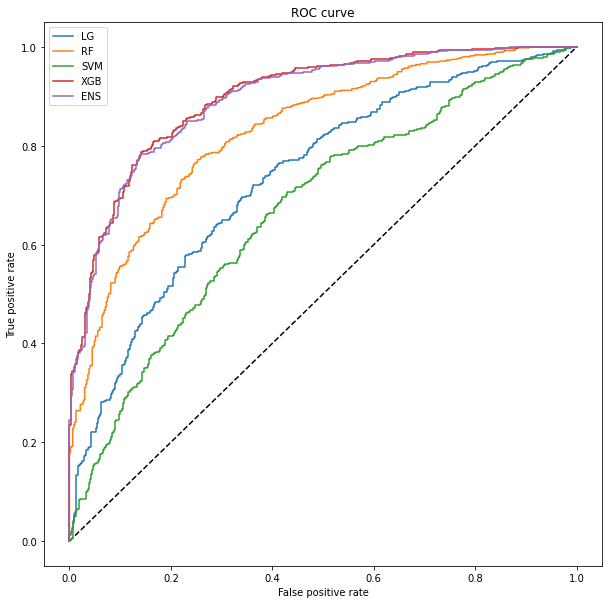

In [127]:
fpr_log, tpr_log, thresholds_log = metrics.roc_curve(full['Win'], LG.predict_proba(full[features])[:,1], drop_intermediate=True)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(full['Win'], RF.predict_proba(full[features])[:,1], drop_intermediate=True)
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(full['Win'], SVM.predict_proba(full[features])[:,1], drop_intermediate=True)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(full['Win'], DT.predict_proba(full[features])[:,1], drop_intermediate=True)
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(full['Win'], XGB.predict_proba(full[features])[:,1], drop_intermediate=True)
fpr_ens, tpr_ens, thresholds_ens = metrics.roc_curve(full['Win'], XGB.predict_proba(full[features])[:,1]*.8+RF.predict_proba(full[features])[:,1]*.2, drop_intermediate=True)

plt.figure(figsize=(10,10))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_log, tpr_log, label = 'LG')
plt.plot(fpr_rf, tpr_rf, label = 'RF')
plt.plot(fpr_svm, tpr_svm, label = 'SVM')
plt.plot(fpr_xgb, tpr_xgb, label = 'XGB')
plt.plot(fpr_ens, tpr_ens, label = 'ENS')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve')
plt.show()

Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:33:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


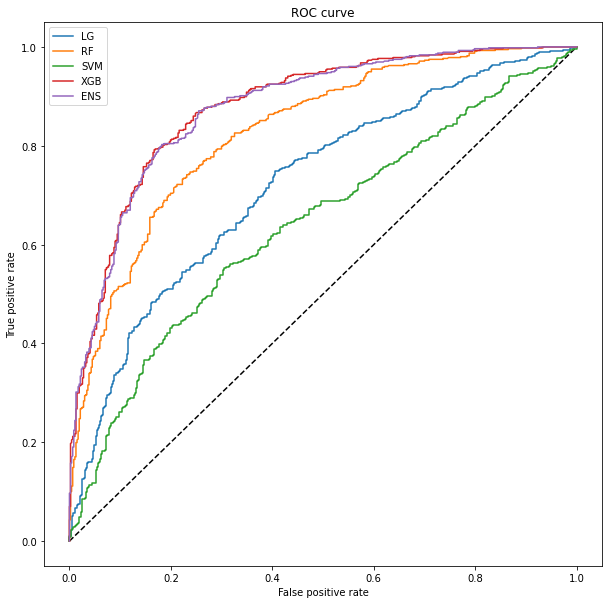

In [128]:
features = list(pd.DataFrame.from_dict({'features':features, 'importance':XGB.feature_importances_}).sort_values(by='importance', ascending=False).iloc[:30, 0])

for x in models:
    x.fit(full[features], full['Win'], sample_weight=full['Weight'])

fpr_log, tpr_log, thresholds_log = metrics.roc_curve(full['Win'], LG.predict_proba(full[features])[:,1], drop_intermediate=True)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(full['Win'], RF.predict_proba(full[features])[:,1], drop_intermediate=True)
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(full['Win'], SVM.predict_proba(full[features])[:,1], drop_intermediate=True)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(full['Win'], DT.predict_proba(full[features])[:,1], drop_intermediate=True)
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(full['Win'], XGB.predict_proba(full[features])[:,1], drop_intermediate=True)
fpr_ens, tpr_ens, thresholds_ens = metrics.roc_curve(full['Win'], XGB.predict_proba(full[features])[:,1]*.8+RF.predict_proba(full[features])[:,1]*.2, drop_intermediate=True)

plt.figure(figsize=(10,10))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_log, tpr_log, label = 'LG')
plt.plot(fpr_rf, tpr_rf, label = 'RF')
plt.plot(fpr_svm, tpr_svm, label = 'SVM')
#plt.plot(fpr_dt, tpr_dt, label = 'DT')
plt.plot(fpr_xgb, tpr_xgb, label = 'XGB')
plt.plot(fpr_ens, tpr_ens, label = 'ENS')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve')
plt.show()

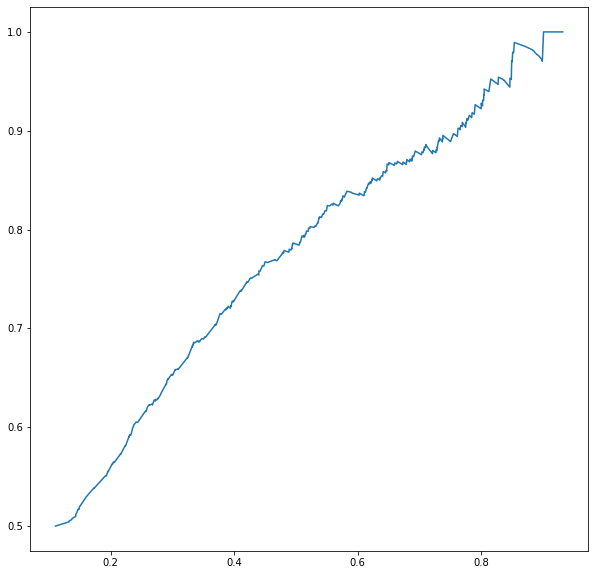

In [129]:
my_dict = {
    'fpr':fpr_xgb,
    'tpr':tpr_xgb,
    'threshold':thresholds_xgb

}

thresholds = pd.DataFrame.from_dict(my_dict)
thresholds['Precision'] = thresholds['tpr']/(thresholds['tpr']+thresholds['fpr'])

plt.figure(figsize=(10,10))
plt.plot(thresholds['threshold'], thresholds['Precision'], label = 'Precision')
plt.show()

In [130]:
thresh = thresholds[(thresholds['tpr']>.8)&(thresholds['fpr']<.2)].reset_index(drop=True).iloc[0,2]
thresh

0.53849995

In [131]:
full.insert(5, 'proba', XGB.predict_proba(full[features])[:,1])
full.insert(5, 'pred', full['proba']>thresh)

full

,Year,Week,Home,Away,Score_Home,pred,proba,Score_Away,Win,G_pass_o,...,Att_rush_d_Away,Yds_rush_d_Away,TD_rush_d_Away,Y/A_rush_d_Away,Y/G_rush_d_Away,EXP_rush_d_Away,Streak_Home,Streak_Away,Weight,Rand_Int
0,2017,1,Patriots,Chiefs,27,True,0.659385,42,False,16,...,443,1890,15,4.3,118.1,56.69,0.0,0.0,0.1,6
1,2017,5,Texans,Chiefs,34,False,0.192853,42,False,16,...,443,1890,15,4.3,118.1,56.69,1.0,4.0,0.1,9
2,2017,9,Cowboys,Chiefs,28,True,0.654890,17,True,16,...,443,1890,15,4.3,118.1,56.69,2.0,1.0,0.1,7
3,2017,17,Broncos,Chiefs,24,False,0.300306,27,False,16,...,443,1890,15,4.3,118.1,56.69,0.0,3.0,0.1,4
4,2017,3,Chargers,Chiefs,10,False,0.505856,24,False,16,...,443,1890,15,4.3,118.1,56.69,0.0,2.0,0.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,2020,10,Bears,Vikings,13,False,0.335739,19,False,16,...,472,2151,19,4.6,134.4,-41.77,0.0,2.0,0.4,4
1020,2020,14,Buccaneers,Vikings,26,True,0.820628,14,True,16,...,472,2151,19,4.6,134.4,-41.77,0.0,2.0,0.4,7
1021,2020,8,Packers,Vikings,22,True,0.788807,28,False,16,...,472,2151,19,4.6,134.4,-41.77,1.0,0.0,0.4,3
1022,2020,4,Texans,Vikings,23,False,0.193239,31,False,16,...,472,2151,19,4.6,134.4,-41.77,0.0,0.0,0.4,3


In [132]:
full['proba_bucket'] = np.floor(full['proba']*10)
full['correct'] = full['Win']==full['pred']

grp = full[['proba_bucket', 'correct']].groupby(['proba_bucket']).mean()
grp = grp.rename(columns={'correct':'correct_pct'})
grp = grp.join(full[['proba_bucket', 'correct']].groupby(['proba_bucket']).count())
grp = grp.rename(columns={'correct':'count'})

grp

,correct_pct,count
proba_bucket,,
1.0,0.953704,108
2.0,0.847682,151
3.0,0.716814,113
4.0,0.615385,78
5.0,0.569892,93
6.0,0.759690,129
7.0,0.839744,156
8.0,0.923567,157
9.0,1.000000,39


In [133]:
average_sum = 0
count = 0
for x in [0,1,2,6,7,8]:
    average_sum+=grp.iloc[x,0]*grp.iloc[x,1]
    count+=grp.iloc[x,1]

average_sum = average_sum/count
pct = count/len(full)

print(f'Average correct for these buckets: {average_sum}')
print(f'Number of games in these buckets: {count}')
print(f'Approx. number of games correct: {average_sum*count}')
print(f'Games in these buckets as a % of all games: {pct}')

Average correct for these buckets: 0.8660220994475138
Number of games in these buckets: 724
Approx. number of games correct: 627.0
Games in these buckets as a % of all games: 0.70703125


In [134]:
grp2 = full[['proba_bucket', 'Win']].groupby(['proba_bucket']).sum()
grp2 = grp2.join(full[['proba_bucket', 'pred']].groupby(['proba_bucket']).sum())
grp2 = grp2.join(full[['proba_bucket', 'Week']].groupby(['proba_bucket']).count())
grp2 = grp2.rename(columns={'Week':'count'})

grp2

,Win,pred,count
proba_bucket,,,
1.0,5,0,108
2.0,23,0,151
3.0,32,0,113
4.0,30,0,78
5.0,54,50,93
6.0,98,129,129
7.0,131,156,156
8.0,145,157,157
9.0,39,39,39


In [135]:
grp2['pct'] = grp2['Win']/grp2['count']

grp2

,Win,pred,count,pct
proba_bucket,,,,
1.0,5,0,108,0.046296
2.0,23,0,151,0.152318
3.0,32,0,113,0.283186
4.0,30,0,78,0.384615
5.0,54,50,93,0.580645
6.0,98,129,129,0.759690
7.0,131,156,156,0.839744
8.0,145,157,157,0.923567
9.0,39,39,39,1.000000


In [136]:
buckets_string =[
    '10-19%',
    '20-29%',
    '30-39%',
    '40-49%',
    '50-59%',
    '60-69%',
    '70-79%',
    '80-89%',
    '90-100%'
    ]
grp2.insert(0, 'Probability Bucket', buckets_string)

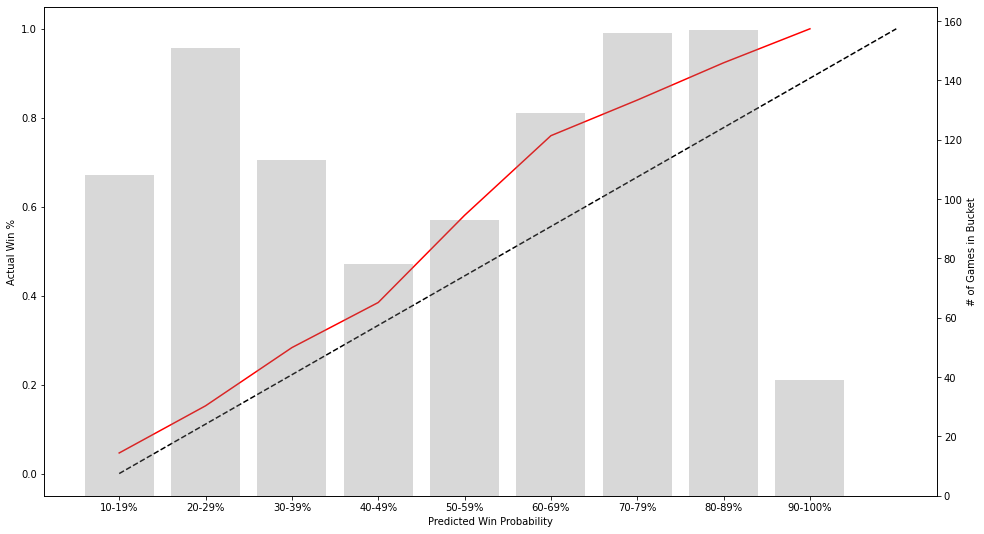

In [137]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax1.plot(grp2['Probability Bucket'], grp2['pct'], label = 'Actual Win %', color='red')
ax2 = ax1.twinx()
ax2.bar(grp2['Probability Bucket'], grp2['count'], label = '# of Games in Bucket', color='gray', alpha=.3)
ax1.plot([0,9], [0,1], 'k--')

ax1.set_xlabel('Predicted Win Probability')
ax1.set_ylabel('Actual Win %')
ax2.set_ylabel('# of Games in Bucket')
plt.show()

## Fit on 2021 Game Results

In [143]:
scores_21 = pd.read_csv('data/nfl_scores_21.csv', sep=';')

scores_21['Home'] = scores_21['Home'].str.split().str[-1]
scores_21['Home'] = scores_21['Home'].str.replace('Team', 'WFT').replace('Redskins', 'WFT')

scores_21['Away'] = scores_21['Away'].str.split().str[-1]
scores_21['Away'] = scores_21['Away'].str.replace('Team', 'WFT').replace('Redskins', 'WFT')


pass_o_21 = pd.read_csv('data/passing_21.csv')
rushing_o_21 = pd.read_csv('data/rushing_21.csv')

pass_d_21 = pd.read_csv('data/passing_d_21.csv')
rushing_d_21=pd.read_csv('data/rushing_d_21.csv')

In [144]:
pass_o_21['scale'] = 16/pass_o_21['G']

for column in list(set(pass_o_21.columns)-set(['Year','G', 'Tm','Cmp%', 'TD%', 'Int%', 'Lng', 'Y/A', 'AY/A', 'Y/C', 'Y/G', 'Rate','Sk%','EXP','scale'])):
    pass_o_21[column]=pass_o_21[column].astype('float')*pass_o_21['scale']

pass_o_21['TD%']=pass_o_21['TD']/pass_o_21['Att']
pass_o_21['Int%']=pass_o_21['Int']/pass_o_21['Att']
pass_o_21['Sk%']=pass_o_21['Sk']/pass_o_21['Att']

pass_o_21 = rename_cols(pass_o_21, '_pass_o')

In [145]:
rushing_o_21['scale'] = 16/rushing_o_21['G']

for column in list(set(rushing_o_21.columns)-set(['Year', 'G', 'Tm', 'Lng', 'Y/A', 'Y/G','EXP', 'scale'])):
    rushing_o_21[column]=rushing_o_21[column].astype('float')*rushing_o_21['scale']

rushing_o_21 = rename_cols(rushing_o_21, '_rush_o')

In [146]:
pass_d_21['scale'] = 16/pass_d_21['G']

for column in list(set(pass_d_21.columns)-set(['Year','G', 'Tm','Cmp%', 'TD%', 'Int%', 'Y/A','NY/A','ANY/A', 'AY/A', 'Y/C', 'Y/G', 'Rate','Sk%','EXP','scale'])):
    pass_d_21[column]=pass_d_21[column].astype('float')*pass_d_21['scale']

pass_d_21['TD%']=pass_d_21['TD']/pass_d_21['Att']
pass_d_21['Int%']=pass_d_21['Int']/pass_d_21['Att']
pass_d_21['Sk%']=pass_d_21['Sk']/pass_d_21['Att']

pass_d_21 = rename_cols(pass_d_21, '_pass_d')

In [147]:
rushing_d_21['scale'] = 16/rushing_d_21['G']

for column in list(set(rushing_d_21.columns)-set(['Year','G', 'Tm', 'Y/A', 'Y/G','EXP','scale'])):
    rushing_d_21[column]=rushing_d_21[column].astype('float')*rushing_d_21['scale']

rushing_d_21 = rename_cols(rushing_d_21, '_rush_d')

In [148]:
offense_21 = pass_o_21.merge(rushing_o_21, on=['Year', 'Tm'])

defense_21 = pass_d_21.merge(rushing_d_21, on=['Year', 'Tm'])

In [149]:
scores_21 = scores_21.merge(offense_21, left_on=['Year', 'Home'], right_on=['Year', 'Tm'])
scores_21 = scores_21.drop(columns='Tm')
scores_21 = scores_21.merge(defense_21, left_on=['Year', 'Home'], right_on=['Year', 'Tm'])
scores_21 = scores_21.drop(columns='Tm')

scores_21 = scores_21.merge(offense_21, left_on=['Year', 'Away'], right_on=['Year', 'Tm'], suffixes=('', '_Away'))
scores_21 = scores_21.drop(columns='Tm')
scores_21 = scores_21.merge(defense_21, left_on=['Year', 'Away'], right_on=['Year', 'Tm'], suffixes=('', '_Away'))
scores_21 = scores_21.drop(columns='Tm')

In [150]:
scores_21

,Year,Week,Home,Away,Win,Home_Score,Away_Score,G_pass_o,Cmp_pass_o,Att_pass_o,...,EXP_pass_d_Away,scale_pass_d_Away,G_rush_d_Away,Att_rush_d_Away,Yds_rush_d_Away,TD_rush_d_Away,Y/A_rush_d_Away,Y/G_rush_d_Away,EXP_rush_d_Away,scale_rush_d_Away
0,2021,1,Buccaneers,Cowboys,1.0,31.0,29.0,9,460.444444,682.666667,...,-5.13,1.777778,9,373.333333,1619.555556,12.444444,4.3,101.2,-0.36,1.777778
1,2021,14,WFT,Cowboys,NaN,NaN,NaN,9,362.666667,554.666667,...,-5.13,1.777778,9,373.333333,1619.555556,12.444444,4.3,101.2,-0.36,1.777778
2,2021,11,Chiefs,Cowboys,NaN,NaN,NaN,10,452.800000,686.400000,...,-5.13,1.777778,9,373.333333,1619.555556,12.444444,4.3,101.2,-0.36,1.777778
3,2021,13,Saints,Cowboys,NaN,NaN,NaN,9,288.000000,485.333333,...,-5.13,1.777778,9,373.333333,1619.555556,12.444444,4.3,101.2,-0.36,1.777778
4,2021,6,Patriots,Cowboys,0.0,29.0,35.0,10,371.200000,532.800000,...,-5.13,1.777778,9,373.333333,1619.555556,12.444444,4.3,101.2,-0.36,1.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2021,5,Steelers,Broncos,1.0,27.0,19.0,9,401.777778,622.222222,...,-29.21,1.600000,10,400.000000,1758.400000,9.600000,4.4,109.9,-0.27,1.600000
268,2021,2,Jaguars,Broncos,0.0,13.0,23.0,9,344.888889,592.000000,...,-29.21,1.600000,10,400.000000,1758.400000,9.600000,4.4,109.9,-0.27,1.600000
269,2021,7,Browns,Broncos,1.0,17.0,14.0,10,305.600000,470.400000,...,-29.21,1.600000,10,400.000000,1758.400000,9.600000,4.4,109.9,-0.27,1.600000
270,2021,17,Chargers,Broncos,NaN,NaN,NaN,9,410.666667,629.333333,...,-29.21,1.600000,10,400.000000,1758.400000,9.600000,4.4,109.9,-0.27,1.600000


In [151]:
scores_data = scores_21[scores_21['Win'].notna()].reset_index(drop=True)
streaks_21 = find_streaks(scores_data)

scores_data = scores_data.merge(streaks_21, left_on=['Year', 'Week', 'Home'], right_on=['Year', 'Week', 'Team'])
scores_data = scores_data.drop(columns=['Team'])
scores_data = scores_data.rename(columns={'Streak':'Streak_Home'})
scores_data = scores_data.merge(streaks_21, left_on=['Year', 'Week', 'Away'], right_on=['Year', 'Week', 'Team'])
scores_data = scores_data.drop(columns=['Team'])
scores_data = scores_data.rename(columns={'Streak':'Streak_Away'})

scores_future = scores_21[scores_21['Win'].isna()].reset_index(drop=True)

for team in scores_future['Home'].unique():
    temp = streaks_21[streaks_21['Team']==team][['Team','Week','Streak']]
    streak = temp.iloc[-1,2]
    scores_future.loc[scores_future['Home']==team,'Streak_Home']=streak
    scores_future.loc[scores_future['Away']==team,'Streak_Away']=streak

scores_future.head()

,Year,Week,Home,Away,Win,Home_Score,Away_Score,G_pass_o,Cmp_pass_o,Att_pass_o,...,G_rush_d_Away,Att_rush_d_Away,Yds_rush_d_Away,TD_rush_d_Away,Y/A_rush_d_Away,Y/G_rush_d_Away,EXP_rush_d_Away,scale_rush_d_Away,Streak_Home,Streak_Away
0,2021,14,WFT,Cowboys,NaN,NaN,NaN,9,362.666667,554.666667,...,9,373.333333,1619.555556,12.444444,4.3,101.2,-0.36,1.777778,0.0,0.0
1,2021,11,Chiefs,Cowboys,NaN,NaN,NaN,10,452.800000,686.400000,...,9,373.333333,1619.555556,12.444444,4.3,101.2,-0.36,1.777778,2.0,0.0
2,2021,13,Saints,Cowboys,NaN,NaN,NaN,9,288.000000,485.333333,...,9,373.333333,1619.555556,12.444444,4.3,101.2,-0.36,1.777778,0.0,0.0
3,2021,15,Giants,Cowboys,NaN,NaN,NaN,9,369.777778,570.666667,...,9,373.333333,1619.555556,12.444444,4.3,101.2,-0.36,1.777778,0.0,0.0
4,2021,18,Eagles,Cowboys,NaN,NaN,NaN,10,297.600000,478.400000,...,9,373.333333,1619.555556,12.444444,4.3,101.2,-0.36,1.777778,0.0,0.0


In [152]:
scores_data.insert(4, 'proba', XGB.predict_proba(scores_data[features])[:,1])
scores_data.insert(4, 'pred', scores_data['proba']>thresh)

scores_data

,Year,Week,Home,Away,pred,proba,Win,Home_Score,Away_Score,G_pass_o,...,G_rush_d_Away,Att_rush_d_Away,Yds_rush_d_Away,TD_rush_d_Away,Y/A_rush_d_Away,Y/G_rush_d_Away,EXP_rush_d_Away,scale_rush_d_Away,Streak_Home,Streak_Away
0,2021,1,Buccaneers,Cowboys,False,0.393775,1.0,31.0,29.0,9,...,9,373.333333,1619.555556,12.444444,4.3,101.2,-0.36,1.777778,0.0,0.0
1,2021,6,Patriots,Cowboys,False,0.475835,0.0,29.0,35.0,10,...,9,373.333333,1619.555556,12.444444,4.3,101.2,-0.36,1.777778,1.0,4.0
2,2021,2,Chargers,Cowboys,False,0.324353,0.0,17.0,20.0,9,...,9,373.333333,1619.555556,12.444444,4.3,101.2,-0.36,1.777778,1.0,0.0
3,2021,8,Vikings,Cowboys,False,0.393036,0.0,16.0,20.0,9,...,9,373.333333,1619.555556,12.444444,4.3,101.2,-0.36,1.777778,2.0,5.0
4,2021,2,Buccaneers,Falcons,True,0.803618,1.0,48.0,25.0,9,...,9,467.555556,1953.777778,17.777778,4.2,122.1,-14.81,1.777778,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,2021,1,Giants,Broncos,False,0.271294,0.0,13.0,27.0,9,...,10,400.000000,1758.400000,9.600000,4.4,109.9,-0.27,1.600000,0.0,0.0
145,2021,5,Steelers,Broncos,False,0.297393,1.0,27.0,19.0,9,...,10,400.000000,1758.400000,9.600000,4.4,109.9,-0.27,1.600000,0.0,0.0
146,2021,2,Jaguars,Broncos,False,0.362742,0.0,13.0,23.0,9,...,10,400.000000,1758.400000,9.600000,4.4,109.9,-0.27,1.600000,0.0,1.0
147,2021,7,Browns,Broncos,False,0.492277,1.0,17.0,14.0,10,...,10,400.000000,1758.400000,9.600000,4.4,109.9,-0.27,1.600000,0.0,0.0


In [153]:
scores_data['proba_bucket'] = np.floor(scores_data['proba']*20)
scores_data['correct'] = scores_data['Win']==scores_data['pred']

grp = scores_data[['proba_bucket', 'correct']].groupby(['proba_bucket']).mean()
grp = grp.rename(columns={'correct':'correct_pct'})
grp = grp.join(scores_data[['proba_bucket', 'correct']].groupby(['proba_bucket']).count())
grp = grp.rename(columns={'correct':'count'})

grp

,correct_pct,count
proba_bucket,,
3.0,1.000000,2
4.0,0.666667,3
5.0,0.800000,5
6.0,0.727273,11
7.0,0.857143,14
8.0,0.666667,6
9.0,0.545455,11
10.0,0.600000,10
11.0,0.545455,11


In [154]:
average_sum = 0
count = 0
for x in [0,1,2,3,4,5,11,12,13,14,15]:
    average_sum+=grp.iloc[x,0]*grp.iloc[x,1]
    count+=grp.iloc[x,1]

average_sum = average_sum/count
pct = count/len(scores_data)

print(f'Average correct for these buckets: {average_sum}')
print(f'Number of games in these buckets: {count}')
print(f'Approx. number of games correct: {average_sum*count}')
print(f'Games in these buckets as a % of all games: {pct}')

Average correct for these buckets: 0.7840909090909091
Number of games in these buckets: 88
Approx. number of games correct: 69.0
Games in these buckets as a % of all games: 0.5906040268456376


In [155]:
grp2 = scores_data[['proba_bucket', 'Win']].groupby(['proba_bucket']).sum()
grp2 = grp2.join(scores_data[['proba_bucket', 'pred']].groupby(['proba_bucket']).sum())
grp2 = grp2.join(scores_data[['proba_bucket', 'Week']].groupby(['proba_bucket']).count())
grp2 = grp2.rename(columns={'Week':'count'})

grp2

,Win,pred,count
proba_bucket,,,
3.0,0.0,0,2
4.0,1.0,0,3
5.0,1.0,0,5
6.0,3.0,0,11
7.0,2.0,0,14
8.0,2.0,0,6
9.0,5.0,0,11
10.0,4.0,2,10
11.0,6.0,11,11


In [156]:
grp2['pct'] = grp2['Win']/grp2['count']

grp2

,Win,pred,count,pct
proba_bucket,,,,
3.0,0.0,0,2,0.000000
4.0,1.0,0,3,0.333333
5.0,1.0,0,5,0.200000
6.0,3.0,0,11,0.272727
7.0,2.0,0,14,0.142857
8.0,2.0,0,6,0.333333
9.0,5.0,0,11,0.454545
10.0,4.0,2,10,0.400000
11.0,6.0,11,11,0.545455


In [157]:
buckets_string =[
    f'{i} - {i+4}%' for i in range(int(min(grp2.index)*5),int(max(grp2.index)*5)+1,5)
    ]
grp2.insert(0, 'Probability Bucket', buckets_string)

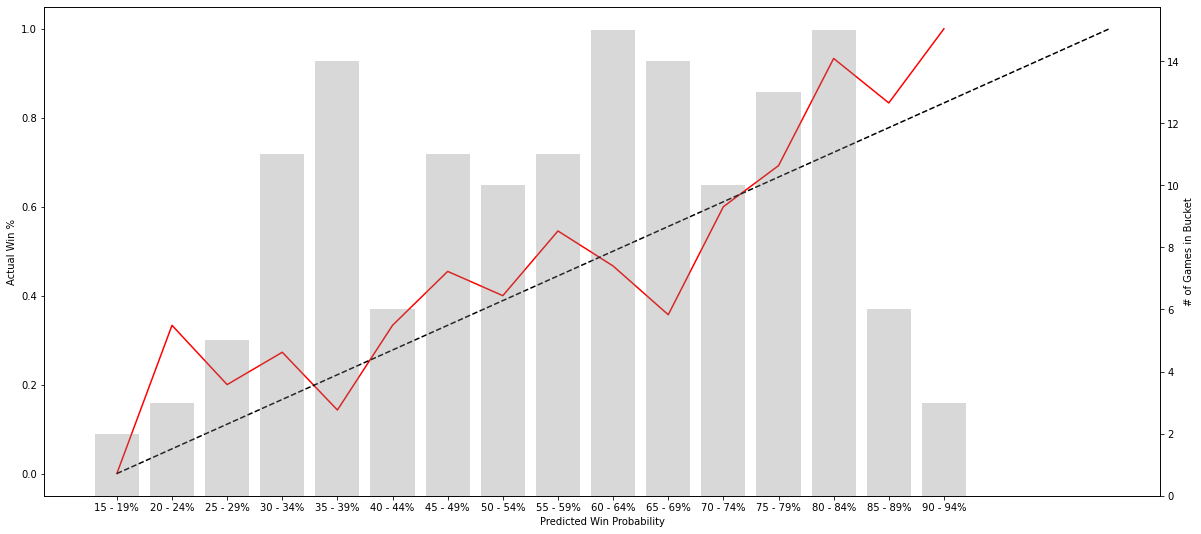

In [158]:
fig, ax1 = plt.subplots(figsize=(20,9))
ax1.plot(grp2['Probability Bucket'], grp2['pct'], label = 'Actual Win %', color='red')
ax2 = ax1.twinx()
ax2.bar(grp2['Probability Bucket'], grp2['count'], label = '# of Games in Bucket', color='gray', alpha=.3)
ax1.plot([0,max(grp2.index)], [0,1], 'k--')

ax1.set_xlabel('Predicted Win Probability')
ax1.set_ylabel('Actual Win %')
ax2.set_ylabel('# of Games in Bucket')
plt.show()

In [159]:
scores_future.insert(4, 'proba', XGB.predict_proba(scores_future[features])[:,1])
scores_future.insert(4, 'pred', scores_future['proba']>thresh)

scores_data.to_csv('output/21_preds_played_games.csv')
scores_future.to_csv('output/21_preds_future_games.csv')

In [160]:
scores.to_csv('test.csv')

# Score Prediction
Try a similar model but we set score as our target variable

## Data Prep

In [182]:
np.random.seed(69)

scores_df = full.copy()

scores_df['Rand_Int'] = np.random.randint(10,size=len(scores_df))
scores_df = scores_df.fillna(0)

features = list(scores_df.columns)
features.remove('Away')
features.remove('Weight')
features.remove('Home')
features.remove('Score_Home')
features.remove('Score_Away')
features.remove('Win')
features.remove('Rand_Int')
features.remove('correct')

scores_test = scores_df[scores_df['Rand_Int']>=8].reset_index(drop=True)
scores_train = scores_df[scores_df['Rand_Int']<8].reset_index(drop=True)

home_ytrain = scores_train['Score_Home']
home_xtrain = scores_train.drop(columns=['Score_Home'])

home_ytest = scores_test['Score_Home']
home_xtest = scores_test.drop(columns=['Score_Home'])

away_ytrain = scores_train['Score_Away']
away_xtrain = scores_train.drop(columns=['Score_Away'])

away_ytest = scores_test['Score_Away']
away_xtest = scores_test.drop(columns=['Score_Away'])


In [183]:
from xgboost import XGBRegressor
from sklearn import metrics

XGB = XGBRegressor(n_estimators=10, max_depth=4, n_jobs=-1, objective='reg:squarederror', eval_metric = metrics.mean_squared_error)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x000001F9977A38B8>,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

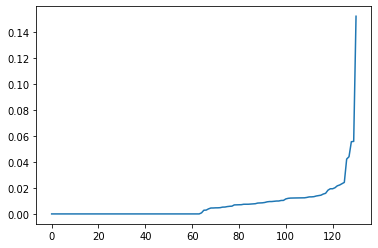

In [184]:
XGB.fit(home_xtrain[features], home_ytrain, sample_weight=home_xtrain['Weight'])

plt.plot(np.sort(XGB.feature_importances_))

XGB.fit(home_xtrain[features], home_ytrain, sample_weight=home_xtrain['Weight'])

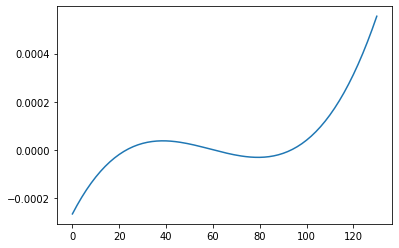

In [185]:
from numpy.polynomial import polynomial

Reg = polynomial.Polynomial((0,0,0))
new_series = Reg.fit(np.arange(len(XGB.feature_importances_)), np.sort(XGB.feature_importances_), 5)

new_series = new_series.deriv(2)

plt.plot(new_series(np.arange(len(XGB.feature_importances_))))

In [186]:
import math
idx = round(pd.DataFrame.from_dict({'importances_deriv':abs(new_series(np.arange(len(XGB.feature_importances_))))}).sort_values(by='importances_deriv')[:(math.floor(len(XGB.feature_importances_)/10))].index.max(),-2)
features = list(pd.DataFrame.from_dict({'features':features, 'importance':XGB.feature_importances_}).sort_values(by='importance', ascending=False).iloc[:(len(XGB.feature_importances_)-idx), 0])
XGB.fit(home_xtrain[features], home_ytrain, sample_weight=home_xtrain['Weight'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x000001F9977A38B8>,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


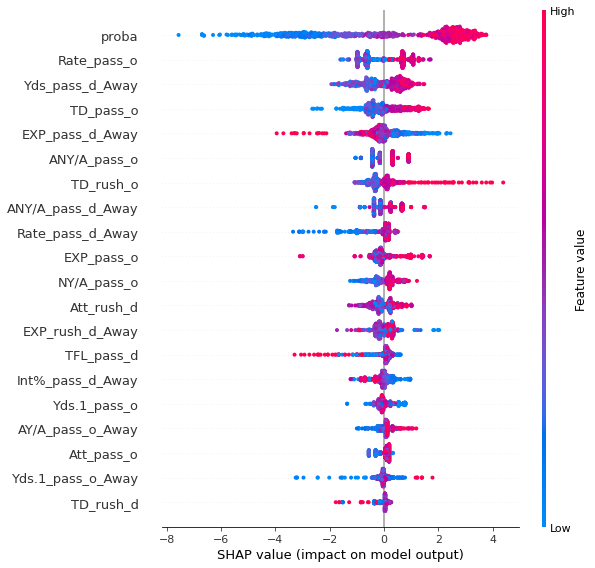

In [187]:
shapvalues = shap.TreeExplainer(XGB).shap_values(home_xtrain[features])


shap.summary_plot(shapvalues, home_xtrain[features])

In [188]:
(metrics.mean_squared_error(home_ytest, XGB.predict(home_xtest[features])))**.5

9.230093245434764

In [189]:
pd.DataFrame.from_dict({'True':home_ytest, 'Pred':XGB.predict(home_xtest[features])})

,True,Pred
0,34,19.632566
1,12,18.781038
2,38,17.639181
3,33,28.786936
4,24,24.264500
...,...,...
212,17,19.768667
213,38,28.493273
214,30,20.457014
215,35,19.341949


In [190]:
features

['Rate_pass_o',
 'ANY/A_pass_o',
 'TD_pass_o',
 'proba',
 'ANY/A_pass_d_Away',
 'NY/A_pass_o',
 'EXP_pass_d_Away',
 'Yds.1_pass_o_Away',
 'AY/A_pass_o_Away',
 'Yds_pass_d_Away',
 'QBHits_pass_d',
 'Lng_rush_o_Away',
 'ANY/A_pass_o_Away',
 'TD_rush_o',
 'EXP_pass_o',
 'Att_pass_d',
 'EXP_rush_o_Away',
 'Int%_pass_o',
 'EXP_rush_d_Away',
 'Lng_rush_o',
 'Att_rush_d',
 'TD_rush_d',
 'Lng_pass_o',
 'TFL_pass_d',
 'Int%_pass_d_Away',
 'Rate_pass_d_Away',
 'Yds.1_pass_o',
 'Att_pass_o',
 'Int_pass_d',
 'Cmp_pass_o',
 'Att_pass_o_Away']

In [191]:
features = list(scores_df.columns)
features.remove('Away')
features.remove('Weight')
features.remove('Home')
features.remove('Score_Home')
features.remove('Score_Away')
features.remove('Win')
features.remove('Rand_Int')
features.remove('correct')

XGB.fit(away_xtrain[features], away_ytrain, sample_weight=away_xtrain['Weight'])

features = list(pd.DataFrame.from_dict({'features':features, 'importance':XGB.feature_importances_}).sort_values(by='importance', ascending=False).iloc[:30, 0])

XGB.fit(away_xtrain[features], away_ytrain, sample_weight=away_xtrain['Weight'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x000001F9977A38B8>,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [192]:
(metrics.mean_squared_error(away_ytest, XGB.predict(away_xtest[features])))**.5

9.372752738254373

In [193]:
from sklearn.model_selection import GridSearchCV

params = {
        'n_estimators' : [5, 7, 10, 30, 50],
        'min_child_weight': [5, 10, 20],
        'gamma': [.5, 1, 1.5],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

grid = GridSearchCV(estimator=XGB, param_grid=params, n_jobs=-1)

grid.fit(home_xtrain[features], home_ytrain, sample_weight=home_xtrain['Weight'])

print(f'Best estimator: {grid.best_estimator_}')
print(f'\n Best score: {grid.best_score_**.5}')
print(f'\n Best parameters: {grid.best_params_}')

Best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x000001F9977A38B8>,
             gamma=0.5, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=20, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

 Best score: 0.4302070081868326

 Best parameters: {'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 20, 'n_estimators': 10, 'subsample': 0.8}


In [194]:
XGB_home = grid.best_estimator_

metrics.mean_squared_error(home_ytest, XGB_home.predict(home_xtest[features]))**.5

8.964546459408572

In [195]:
metrics.mean_absolute_error(home_ytest, XGB_home.predict(home_xtest[features]))

6.819844149224769

(array([ 2.,  0.,  3.,  2.,  4.,  3., 19., 16., 26., 18., 27., 43., 20.,
        17.,  5.,  4.,  6.,  0.,  1.,  1.]),
 array([-30.90107822, -28.04937873, -25.19767923, -22.34597974,
        -19.49428024, -16.64258075, -13.79088125, -10.93918176,
         -8.08748226,  -5.23578277,  -2.38408327,   0.46761622,
          3.31931572,   6.17101521,   9.02271471,  11.87441421,
         14.7261137 ,  17.5778132 ,  20.42951269,  23.28121219,
         26.13291168]),
 <BarContainer object of 20 artists>)

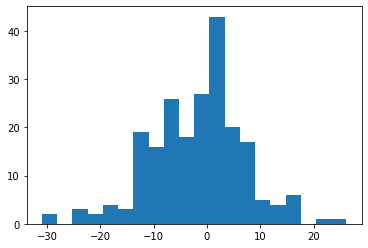

In [196]:
resid = pd.DataFrame.from_dict({'Actual':home_ytest, 'Pred':XGB_home.predict(home_xtest[features])})

plt.hist(resid['Pred']-resid['Actual'], bins=20)

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


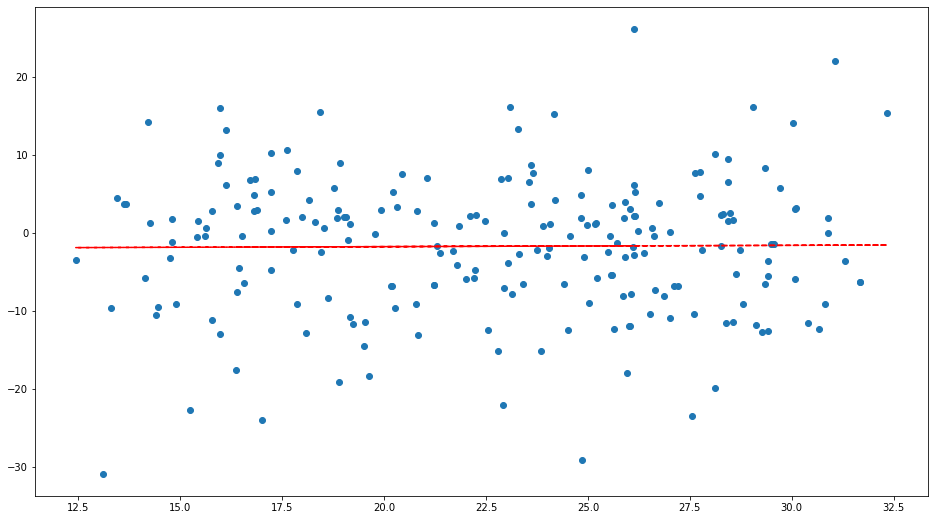

In [197]:
fig, ax = plt.subplots(figsize=(16,9))

ax.scatter(resid['Pred'], (resid['Pred']-resid['Actual']))

m,b = np.polyfit(resid['Pred'], (resid['Pred']-resid['Actual']),1)

ax.plot(resid['Pred'], m*resid['Pred']+b, color='red', lineStyle='dashed')


In [198]:
grid.fit(away_xtrain[features], away_ytrain, sample_weight=away_xtrain['Weight'])

print(f'Best estimator: {grid.best_estimator_}')
print(f'\n Best score: {grid.best_score_**.5}')
print(f'\n Best parameters: {grid.best_params_}')

Best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x000001F9977A38B8>,
             gamma=0.5, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

 Best score: 0.455617223038688

 Best parameters: {'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 10, 'subsample': 1.0}


In [199]:
(resid['Pred']-resid['Actual']).describe()

count    217.000000
mean      -1.754907
std        8.811424
min      -30.901078
25%       -6.888029
50%       -0.589355
75%        3.309031
max       26.132912
dtype: float64

In [200]:
XGB_away = grid.best_estimator_

metrics.mean_squared_error(away_ytest, XGB_away.predict(home_xtest[features]))**.5

9.176225058382483

In [204]:
scores_future.insert(4, 'Score_Away_Pred', XGB_away.predict(scores_future[features]))
scores_future.insert(4, 'Score_Home_Pred', XGB_home.predict(scores_future[features]))

scores_future.to_csv('pred_scores_21_future_games.csv')

In [ ]:
XGB_home.predict(scores_future[features])[:]

array([19.328197, 22.701471, 22.213024, 16.21181 , 19.044456, 20.459955,
       29.425905, 29.425905, 23.97412 , 24.84186 , 29.425905, 24.84186 ,
       29.425905, 21.094585, 22.149822, 25.448893, 28.204304, 29.042746,
       29.059313, 29.425905, 20.031445, 21.14238 , 24.296185, 28.37852 ,
       22.2422  , 22.924625, 20.456049, 18.178442, 16.429512, 24.911848,
       19.896791, 24.220797, 19.409971, 21.417877, 26.959295, 26.959295,
       27.64172 , 21.094585, 25.9691  , 24.51684 , 20.68311 , 20.031445,
       22.829472, 23.47283 , 21.84778 , 25.564928, 27.46624 , 31.675783,
       24.85516 , 30.521994, 26.458797, 21.31091 , 16.204832, 22.2422  ,
       21.534063, 17.036547, 20.0302  , 21.575533, 20.606522, 23.596676,
       19.54338 , 26.516068, 25.448893, 24.299139, 28.204304, 27.131212,
       21.071243, 18.772615, 28.37852 , 21.804071, 27.360426, 22.129091,
       17.823042, 18.772615, 19.024847, 16.564415, 24.809984, 20.150415,
       26.959295, 20.0638  , 26.576136, 25.508043, 